Business Understanding

In [1]:
%load_ext autoreload
%autoreload 2

Data Understaning

In [2]:
from genres import collect_genre_features

In [3]:
genre_playlists = {
    'bluegrass':'https://www.youtube.com/playlist?list=PLKUA473MWUv2mddNMPh-MJkgTR5AjTpl3',
    'blues':'https://www.youtube.com/playlist?list=PLxvodScTx2RuB7Yh_d21kD0HDZvDXWBbY',
    'folk':'https://www.youtube.com/playlist?list=PLGBuKfnErZlBLNzS_JlDAeiH5aW26rvHc',
    'classic_rock':'https://www.youtube.com/playlist?list=PLNxOe-buLm6cz8UQ-hyG1nm3RTNBUBv3K'
}
# collect_genre_features(genre_playlists, data_fp='data/extra_genre_features.json')

In [25]:
import pandas as pd
import numpy as np

In [5]:
df_extra = pd.read_json('data/extra_genre_features.json', lines=True)

In [6]:
df_extra.groupby('genre').song.nunique()

genre
bluegrass       87
blues           92
classic_rock    80
folk            74
Name: song, dtype: int64

In [7]:
df_extra.groupby('genre').song.count()

genre
bluegrass       2083
blues           2206
classic_rock    1920
folk            1773
Name: song, dtype: int64

Not perfect but a reasonable chunk.

### Lets Pickle them for storage on git.

In [8]:
import pickle

In [9]:
with open('data/extra_genre_features.pkl', 'wb') as f:
    pickle.dump(df_extra.to_json(), f)

In [10]:
df_original = pd.read_json('data/genre_features.json', lines=True)

In [11]:
with open('data/genre_features.pkl', 'wb') as f:
    pickle.dump(df_original.to_json(), f)

### Data Preparation

Putting the old with the new.

In [12]:
with open('data/genre_features.pkl', 'rb') as f:
    df_original = pd.read_json(pickle.load(f))
with open('data/extra_genre_features.pkl', 'rb') as f:
    df_extra = pd.read_json(pickle.load(f))

In [13]:
df = pd.concat([df_original, df_extra])

In [14]:
from sklearn.model_selection import train_test_split

y = df['genre']
X = df.drop(['genre', 'song'], axis=1)
X_model, X_val, y_model, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=111,
    stratify=y
)
X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y_model,
    test_size=0.2,
    random_state=111,
    stratify=y_model
)

In [15]:
y.value_counts()

metal           2399
jazz            2397
country         2389
electronic      2371
hip_hop         2345
classical       2320
blues           2206
bluegrass       2083
classic_rock    1920
folk            1773
Name: genre, dtype: int64

In [16]:
tt_split_dists = pd.concat(
    [
        y_train.value_counts(sort=False),
        y_test.value_counts(sort=False),
        y_val.value_counts(sort=False)
    ],
    axis=1,
    sort=False
)
tt_split_dists

,genre,genre,genre
classic_rock,1229,307,384
classical,1485,371,464
metal,1535,384,480
electronic,1517,380,474
bluegrass,1333,333,417
country,1529,382,478
hip_hop,1501,375,469
blues,1412,353,441
folk,1134,284,355
jazz,1534,384,479


In [17]:
tt_split_dists.plot.bar(legend=False);

Displots for genres - x x - x - x x- x- x- x

### Modeling

First run to compare with prior best performer

In [18]:
labels = list(df.genre.unique())

In [19]:
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from genres import eval_model
svc_model = SVC(
    C=10,
    gamma=0.25,
    probability=True,
)
svc = Pipeline([
    ('scaling', PowerTransformer()),
    ('model', svc_model)
])
svc.fit(X_train, y_train)
pred_probas = svc.predict_proba(X_test)
preds = svc.predict(X_test)
eval_model(y_test, preds, pred_probas, labels)


    Log Loss:
        0.5420860921319274
    Jaccard:
        0.72228
	-Country: 0.6179)
	-Jazz: 0.8381)
	-Hip_Hop: 0.64871)
	-Classical: 0.78231)
	-Metal: 0.73288)
	-Electronic: 0.63736)
	-Bluegrass: 0.81148)
	-Blues: 0.70892)
	-Folk: 0.73292)
	-Classic_Rock: 0.71221)


And what about it's competitor?

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA

In [21]:
# gbt_model = GradientBoostingClassifier(
#     max_depth=6,
#     n_estimators=200,
#     subsample=0.8,
# )
# gbt = Pipeline([
#     ('pca', PCA()),
#     ('model', gbt_model)
# ])
# gbt.fit(X_train, y_train)
# pred_probas = gbt.predict_proba(X_test)
# preds = gbt.predict(X_test)
# eval_model(y_test, preds, pred_probas, labels)

It still appears that Support Vectors are outperforming the tree models.

#### Fine Tuning

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss

scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

In [39]:
params = {
    'model__C': [5,9,12,20],
    'model__gamma': [0.25, 2, 5, 'auto', 'scale'],
    'model__tol': [0.01, 0.001, 0.0001]
}
svc_grid = GridSearchCV(
    estimator=svc,
    param_grid=params,
    n_jobs=-1,
    cv=5,
    error_score=np.nan,
    iid=True,
    scoring=scorer,
    pre_dispatch=8,
)
svc_grid.fit(X_train, y_train)

eval_model(
    y_test,
    svc_grid.predict(X_test),
    svc_grid.predict_proba(X_test),
    labels=labels
)


    Log Loss:
        0.5417384211671199
    Jaccard:
        0.721
	-Country: 0.61707)
	-Jazz: 0.8381)
	-Hip_Hop: 0.64871)
	-Classical: 0.78231)
	-Metal: 0.72893)
	-Electronic: 0.63596)
	-Bluegrass: 0.80926)
	-Blues: 0.70657)
	-Folk: 0.73292)
	-Classic_Rock: 0.71014)


In [41]:
svc_grid.best_params_

{'model__C': 9, 'model__gamma': 0.25, 'model__tol': 0.01}

Very little improvement over prior grid searches.

### Evaluation

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn')

In [49]:
svc = svc_grid.best_estimator_
svc.fit(X_model, y_model)
pred_probas = svc.predict_proba(X_val)
preds = svc.predict(X_val)
eval_model(y_val, preds, pred_probas, labels)


    Log Loss:
        0.476540106698385
    Jaccard:
        0.74896
	-Country: 0.65398)
	-Jazz: 0.85605)
	-Hip_Hop: 0.68021)
	-Classical: 0.82375)
	-Metal: 0.73321)
	-Electronic: 0.67199)
	-Bluegrass: 0.8385)
	-Blues: 0.72727)
	-Folk: 0.76963)
	-Classic_Rock: 0.73502)


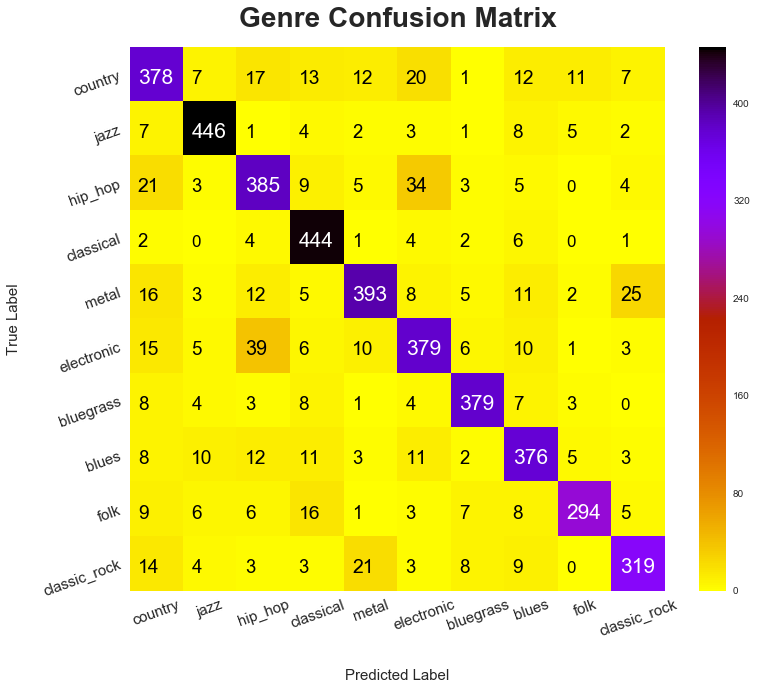

In [123]:
plt.figure(figsize=(12,10))
cm = confusion_matrix(y_val, preds, labels=labels)
n = len(cm)
size = 15
ax = sns.heatmap(cm, cmap='gnuplot_r')
ax.set_ylim(n,0)
ax.set_ylabel('True Label', labelpad=20, size=size)
ax.set_xlabel('Predicted Label', labelpad=30, size=size)
ax.set_xticklabels(labels, rotation=20, size=size)
ax.set_yticklabels(labels, rotation=20, size=size)
thresh = cm.max()/2
for i,j in itertools.product(range(n),range(n)):
    val = cm[i,j]
    plt.text(
        x=j+0.15,
        y=i+0.67,
        s=val,
        color='white' if val>thresh else 'black',
        size=18 + np.log(val + 0.1)/2
    )
plt.title(
    'Genre Confusion Matrix',
    pad=20,
    fontdict={'fontweight': 'bold', 'fontsize': 28}
);

In [81]:
from genres import percentify_cm

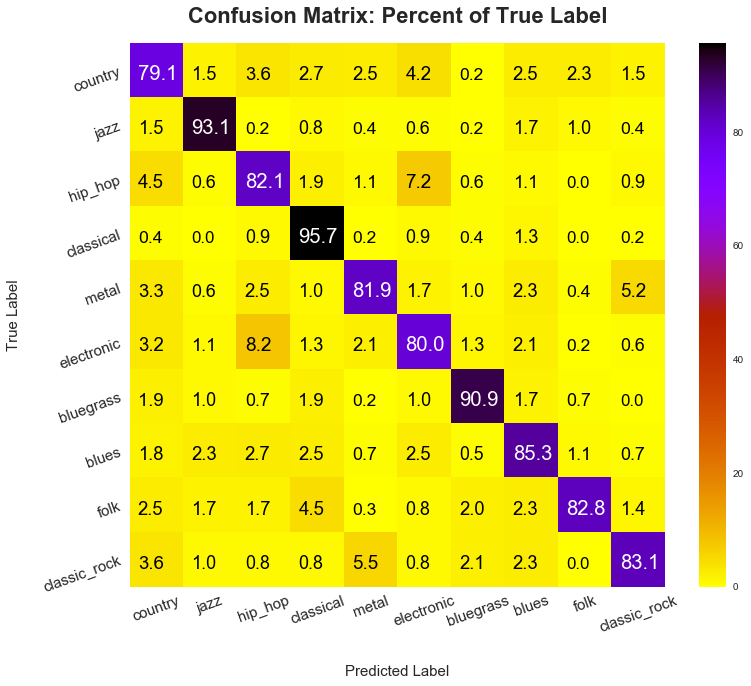

In [122]:
plt.figure(figsize=(12,10))
pcm = percentify_cm(cm)
size = 15
ax = sns.heatmap(pcm, cmap='gnuplot_r')
ax.set_ylim(n,0)
ax.set_ylabel('True Label', labelpad=20, size=size)
ax.set_xlabel('Predicted Label', labelpad=30, size=size)
ax.set_xticklabels(labels, rotation=20, size=size)
ax.set_yticklabels(labels, rotation=20, size=size)
thresh = pcm.max()/2
for i,j in itertools.product(range(n),range(n)):
    val = pcm[i,j]
    plt.text(
        x=j+0.15,
        y=i+0.67,
        s=val,
        color='white' if val>thresh else 'black',
        size=18 + np.log(val + 0.1)/2
    )
plt.title(
    'Confusion Matrix: Percent of True Label',
    pad=20,
    fontdict={'fontweight': 'bold', 'fontsize': 22}
);

Not much worse performance for adding 4 classes 😎 

#### Deployment